# Masked Language Modelling and Sequence Classification with Bert
### HW3 @ DL Course, Dr. Soleymani

*Full Name:* amir khazama

*SID:* 99105391

In this notebook, we leverage the "rotten_tomatoes" dataset from HuggingFace, containing movie reviews from Rotten Tomatoes. Our objectives are twofold:


1.   Perform Masked Language Modeling (MLM) on the training portion of provided dataset.
2.   Construct a classifier to discern between positive and negative reviews.

To achieve these goals, we employ a customized smaller version of BERT. This choice facilitates training and computation, ensuring efficiency and feasibility.

In [ ]:

%%capture
!pip install datasets
!pip install transformers
!pip install evaluate
!pip install accelerate -U
!pip install -U datasets huggingface_hub fsspec

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from datasets import load_dataset
import matplotlib.pyplot as plt

In [ ]:
# Set up basic configurations for training
batch_size = 32
learning_rate = 1e-5
num_epoch = 5
num_labels = 2
np.random.seed(42)
torch.manual_seed(42)

# Select device for training (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load the Rotten Tomatoes dataset
dataset = load_dataset('rotten_tomatoes')
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.46k [00:00<?, ?B/s]

train.parquet:   0%|          | 0.00/699k [00:00<?, ?B/s]

validation.parquet:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/92.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [ ]:
len(dataset['train'])

8530

In all subsequent sections, we utilize the pre-trained BERT tokenizer. Thus, we begin by importing and initializing it here.

In [ ]:
# Import BertTokenizer from the transformers library
from transformers import BertTokenizer

# Load the pre-trained BertTokenizer model 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

We will utilize this configuration for the BERT model in subsequent sections.

In [ ]:
# Import BertConfig from the transformers library
from transformers import BertConfig

# Define configuration parameters for the BERT model
config = BertConfig(
    hidden_size = 384,
    vocab_size= tokenizer.vocab_size,
    num_hidden_layers = 6,
    num_attention_heads = 6,
    intermediate_size = 1024,
    max_position_embeddings = 256
)

# 1 Masked Language Modeling

Masked Language Modeling (MLM) is a fundamental task in natural language processing (NLP) where a `head` is placed on top of a `BERT` (Bidirectional Encoder Representations from Transformers) model to `perform predictions`.
In MLM, certain words or tokens in a sentence are randomly masked or replaced with a special token, and the model is trained to predict the original words based on the context of the surrounding tokens. The objective of MLM is to encourage the model to learn contextual relationships between words and understand the overall structure and semantics of the language. During training, the model receives input sequences with masked tokens and is trained to generate the correct tokens for the masked positions. MLM serves as a crucial pre-training step in learning rich contextual representations of words, which can be transferred to downstream tasks such as text classification, named entity recognition, and question answering.
![](https://editor.analyticsvidhya.com/uploads/22971fig-3.png)
---

## 1.1 Dateset preparation for MLM

In [ ]:
# Define a function to preprocess text data for masked language modeling (MLM)
def mlm_map_function(rows):
    # Tokenize the text with specified tokenizer parameters
    input_info = tokenizer(rows['text'], max_length=128, padding="max_length", truncation=True, return_tensors='pt')
    return {
        **input_info,
        'labels': input_info['input_ids']
        }

# Apply the mlm_map_function to the dataset for masked language modeling (MLM)
mlm_dataset = dataset.map(mlm_map_function, batched=True, num_proc=2, remove_columns=dataset['train'].column_names)

Map (num_proc=2):   0%|          | 0/8530 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1066 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
print(dataset['train'])
print(mlm_dataset['train'])

Dataset({
    features: ['text', 'label'],
    num_rows: 8530
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 8530
})


In [ ]:
text = "I love transformers increasingly I'm at an astonishigly higher masterfully human-designed !"
tokens = tokenizer(text, max_length=128, padding="max_length", truncation=True, return_tensors='pt')
# token_ids = tokenizer.convert_tokens_to_ids(tokens)

# print("Tokens:", tokens)
# print("Token IDs:", token_ids)

print(tokenizer.decode(tokens['input_ids'][0]))

[CLS] i love transformers increasingly i'm at an astonishigly higher masterfully human - designed! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [ ]:
# Import DataCollatorForLanguageModeling from transformers
from transformers import DataCollatorForLanguageModeling

# Create a data collator for MLM training
collate_fn = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

# Create a DataLoader for MLM training
train_dataloader = torch.utils.data.DataLoader(
    mlm_dataset['train'],
    collate_fn=collate_fn,
    batch_size=batch_size
    )


In [ ]:
print(tokenizer.decode(mlm_dataset['train']['input_ids'][0]))
print(tokenizer.decode(mlm_dataset['train']['labels'][0]))


print(tokenizer.decode(collate_fn([mlm_dataset['train'][0]])['input_ids'][0]))


print(tokenizer.decode(collate_fn([mlm_dataset['train'][0]])['labels'][0]))

[CLS] the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger, jean - claud van damme or steven segal. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[CLS] the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger, jean - claud van damme or steven segal. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [ ]:
# 2. Define raw examples
examples = ["the dog barked", "a cat meowed"]

# 3. Tokenize them individually (no batching yet)
tokenized_examples = [tokenizer(text, max_length=6, padding="max_length", truncation=True, return_special_tokens_mask=True) for text in examples]

# 4. Create collator
collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.4

)

# 5. Use collator to form a batch (simulate DataLoader behavior)
batch = collator(tokenized_examples)

# 6. Decode to inspect
decoded_input = [tokenizer.convert_ids_to_tokens(ids) for ids in batch["input_ids"]]
decoded_labels = [tokenizer.convert_ids_to_tokens(ids) for ids in batch["labels"]]

# 7. Print
print("Input IDs (with [MASK] where applied):")
for tokens in decoded_input:
    print(tokens)

print("\nLabels (only masked positions kept, others replaced with [PAD] here):")
for tokens in decoded_labels:
    print(tokens)


Input IDs (with [MASK] where applied):
['[CLS]', 'the', 'dog', '[MASK]', '[SEP]', '[PAD]']
['[CLS]', '[MASK]', '[MASK]', '[MASK]', '##owed', '[SEP]']

Labels (only masked positions kept, others replaced with [PAD] here):
['[UNK]', '[UNK]', '[UNK]', 'barked', '[UNK]', '[UNK]']
['[UNK]', 'a', 'cat', 'me', '[UNK]', '[UNK]']


In [ ]:
batch["labels"]

tensor([[ -100,  -100,  -100, 17554,  -100,  -100],
        [ -100,  1037,  4937,  2033,  -100,  -100]])

## 1.2 BertModel + MLMHead + Custom trainer

In [ ]:
class MLMHead(nn.Module):
    """
    Multi-Layer Perceptron (MLP) head for Masked Language Modeling (MLM) task.

    Parameters:
        bert_model (torch.nn.Module): BERT model.
        hidden_size (int): Size of the hidden layers in the MLP head. Default is 384.
        vocab_size (int): Size of the vocabulary. Default is 30522.
    """

    def __init__(self, bert_model, hidden_size=384, vocab_size=30522):
        super(MLMHead, self).__init__()
        ######################  TODO  ########################
        ######################  TODO  ########################
        # construct layers and structure of the network
        self.embedder = bert_model
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.activation = nn.GELU()
        self.layernorm = nn.LayerNorm(hidden_size)
        self.decoder = nn.Linear(hidden_size, vocab_size)
        ######################  TODO  ########################
        ######################  TODO  ########################

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the MLMHead module.

        Parameters:
            input_ids (torch.Tensor): Tensor containing input token IDs.
            attention_mask (torch.Tensor): Tensor containing attention mask.

        Returns:
            torch.Tensor: Output tensor of the MLM head.
        """
        ######################  TODO  ########################
        ######################  TODO  ########################
        # implement the forward pass of your model.
        # the sentence, the get the embeddings from your language
        # model, then use the `last_hidden_states` for your MLMHead
        # layer.
        outputs = self.embedder(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_states = outputs.last_hidden_state
        x = self.dense(last_hidden_states)
        x = self.activation(x)
        x = self.layernorm(x)
        output = self.decoder(x)
        ######################  TODO  ########################
        ######################  TODO  ########################

        return output


In [ ]:
from transformers import BertModel
bert = BertModel(config)
######################  TODO  ########################
######################  TODO  ########################
bert.to(device)
mlm_model = MLMHead(bert).to(device)
optimizer = optim.Adam(mlm_model.parameters(), 1e-5)
criterion = nn.CrossEntropyLoss()
######################  TODO  ########################
######################  TODO  ########################

In [ ]:
######################  TODO  ########################
######################  TODO  ########################
# implement your training loop and train your model.
losses = []
for epoch in range(num_epoch):
    mlm_model.train()
    total_loss = 0


    for data in train_dataloader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['labels'].to(device)
        #     features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        scores = mlm_model(input_ids, attention_mask)
        loss = criterion(scores.view(-1, scores.size(-1)), labels.view(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epoch} - Loss: {avg_loss:.4f}")

######################  TODO  ########################
######################  TODO  ########################

Epoch 1/5 - Loss: 9.4141
Epoch 2/5 - Loss: 8.3169
Epoch 3/5 - Loss: 7.7240
Epoch 4/5 - Loss: 7.3532
Epoch 5/5 - Loss: 7.1443


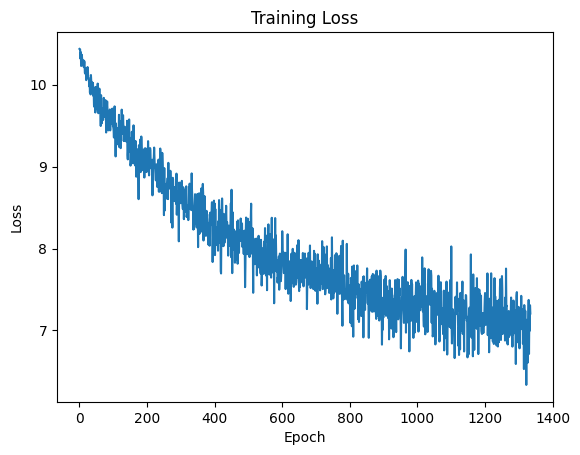

In [ ]:
# Plot the losse for every batch in training process
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
test_sentence = "The quick brown [MASK] jumps over the lazy dog."
inputs = tokenizer(test_sentence, return_tensors='pt')
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)
mlm_model.eval()
with torch.no_grad():
    outputs = mlm_model(input_ids=input_ids, attention_mask=attention_mask)
mask_token_index = (input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1].item()
predicted_token_id = outputs[0, mask_token_index].argmax(dim=-1).item()
predicted_token = tokenizer.decode([predicted_token_id])

print(f"Original sentence: {test_sentence}")
print(f"Predicted token: {predicted_token}")

Original sentence: The quick brown [MASK] jumps over the lazy dog.
Predicted token: .


## 1.3 BertForMaskedLM + huggingface trainer

[HuggingFace library](http://huggingface.co/) has built a nice API for NLP tasks around the transformers. To get familiar with this comrehensive library, In this section you are asked to use the huggingface `Trainer`, `Dataset`, and `BertForMaskedLM` to do what we did above again.

Feel free to refer to the library documentation to learn about these modules.

You should utilize the prepared dataset and configuration from earlier.

In [ ]:
######################  TODO  ########################
######################  TODO  ########################
from transformers import BertForMaskedLM, Trainer, TrainingArguments
model = BertForMaskedLM(config).to(device)
training_args = TrainingArguments(
    output_dir="./mlm_checkpoints",
    overwrite_output_dir=True,
    num_train_epochs=num_epoch,
    per_device_train_batch_size=batch_size,
    save_steps=500,
    save_total_limit=2,
    prediction_loss_only=True,
    logging_dir='./logs',
    logging_steps=100,
    report_to="none"
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=mlm_dataset["train"],
    data_collator=collate_fn,
    tokenizer=tokenizer
)
trainer.train()


######################  TODO  ########################
######################  TODO  ########################

<ipython-input-20-0b3c48a3732d>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,9.083300
200,7.684900
300,7.226400
400,7.046500
500,7.011800
600,6.870100
700,6.830400
800,6.807700
900,6.796500
1000,6.774600


TrainOutput(global_step=1335, training_loss=7.096483712071336, metrics={'train_runtime': 242.4661, 'train_samples_per_second': 175.901, 'train_steps_per_second': 5.506, 'total_flos': 277250297932800.0, 'train_loss': 7.096483712071336, 'epoch': 5.0})

In [ ]:
from transformers import pipeline

fill_mask = pipeline("fill-mask", model=model, tokenizer=tokenizer)

fill_mask("The movie was bad, the production quality was [MASK].")


Device set to use cuda:0


[{'score': 0.04374048486351967,
  'token': 1010,
  'token_str': ',',
  'sequence': 'the movie was bad, the production quality was,.'},
 {'score': 0.03064151294529438,
  'token': 1012,
  'token_str': '.',
  'sequence': 'the movie was bad, the production quality was..'},
 {'score': 0.03044751100242138,
  'token': 1997,
  'token_str': 'of',
  'sequence': 'the movie was bad, the production quality was of.'},
 {'score': 0.027605002745985985,
  'token': 1996,
  'token_str': 'the',
  'sequence': 'the movie was bad, the production quality was the.'},
 {'score': 0.02401692233979702,
  'token': 1998,
  'token_str': 'and',
  'sequence': 'the movie was bad, the production quality was and.'}]

# 2 Sequence Classification

When you look at how `BERT encodes` text, you'll see that it creates a `vector` for each word in the input sentence. But for basic classification tasks, we don't need all those individual word vectors.

Instead, we can just use the `first token's vector` because it captures the overall meaning of the sentence. BERT conveniently provides this vector for us in a special variable called `pooler_output`. So, in our classifier model, we'll use this pooler_output as the input for our classification head.
![BERT pooler output](https://miro.medium.com/max/1100/1*Or3YV9sGX7W8QGF83es3gg.webp)

## 2.1 Dataset preparation for sequence classification

In [ ]:
# Define a function to preprocess text data for classification
def cls_map_function(rows):
    # Tokenize the text with specified tokenizer parameters
    input_info = tokenizer(rows['text'], truncation=True, max_length=128, padding=True)
    return {
        **input_info,
        'labels': rows['label']
        }

# Apply the cls_map_function to the dataset for classification
cls_dataset = dataset.map(cls_map_function, batched=True, num_proc=2, remove_columns=dataset['train'].column_names)

Map (num_proc=2):   0%|          | 0/8530 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1066 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
# Import DataCollatorWithPadding from transformers
from transformers import DataCollatorWithPadding

# Create a data collator with padding
col_fn = DataCollatorWithPadding(
    tokenizer, return_tensors='pt', padding='longest',
)

# Create a DataLoader for training data
train_loader = torch.utils.data.DataLoader(
    cls_dataset['train'],
    batch_size=batch_size,
    collate_fn=col_fn,
    shuffle=True
)

# Create a DataLoader for test data
test_loader = torch.utils.data.DataLoader(
    cls_dataset['test'],
    batch_size=batch_size,
    collate_fn=col_fn,
)

## 2.2 BertModel + ClassifierHead + Custom trainer

In [ ]:
class ClassifierHead(nn.Module):
    """
    Classifier head for classification tasks.

    Parameters:
        embedding_model (torch.nn.Module): bert model.
        num_classes (int): Number of classes for classification. Default is 2.
    """

    def __init__(self, embedding_model, num_classes=2):
        super().__init__()
        ######################  TODO  ########################
        ######################  TODO  ########################
        # construct layers and structure of the network
        self.embedder = embedding_model
        self.classifier = nn.Linear(self.embedder.config.hidden_size, 2 )
        ######################  TODO  ########################
        ######################  TODO  ########################

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the ClassifierHead module.

        Parameters:
            input_ids (torch.Tensor): Tensor containing input token IDs.
            attention_mask (torch.Tensor): Tensor containing attention mask.

        Returns:
            torch.Tensor: Output tensor of the classifier head.
        """
        ######################  TODO  ########################
        ######################  TODO  ########################
        # implement the forward pass of your model.
        # the sentence, the get the embeddings from your language
        # model, then use the `pooler_output` for your classifier
        # layer.
        outputs = self.embedder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        output = logits
        ######################  TODO  ########################
        ######################  TODO  ########################
        return output

In [ ]:
# Define the function to compute metrics
import evaluate
accuracy = evaluate.load("accuracy")

# Define the BERT model
bert = BertModel(config=config)

# Define the classifier head
cls_model = ClassifierHead(bert)
optimizer = optim.Adam(cls_model.parameters(), 1e-5)
criterion = nn.CrossEntropyLoss()
######################  TODO  ########################
######################  TODO  ########################

In [ ]:
######################  TODO  ########################
######################  TODO  ########################
# implement your training loop and train your model.

cls_model.to(device)

# Store accuracy values per epoch if desired
epoch_accuracies = []

for epoch in range(num_epoch):  # Define `epochs` earlier
    cls_model.train()
    total_loss = 0
    predictions = []
    references = []

    for batch in train_loader:  # Define `train_dataloader` earlier
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = cls_model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Store predictions and labels for accuracy
        preds = torch.argmax(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())
        references.extend(labels.cpu().numpy())

    # Compute accuracy using `evaluate`
    acc = accuracy.compute(predictions=predictions, references=references)
    epoch_accuracies.append(acc["accuracy"])

    print(f"Epoch {epoch + 1}/{num_epoch} - Loss: {total_loss:.4f} - Accuracy: {acc['accuracy']:.4f}")
######################  TODO  ########################
######################  TODO  ########################

Epoch 1/5 - Loss: 185.3536 - Accuracy: 0.5111
Epoch 2/5 - Loss: 183.9472 - Accuracy: 0.5386
Epoch 3/5 - Loss: 172.1543 - Accuracy: 0.6353
Epoch 4/5 - Loss: 136.2249 - Accuracy: 0.7474
Epoch 5/5 - Loss: 109.5420 - Accuracy: 0.8150


## 2.3 BertForSequenceClassification + Hugginface Trainer

[HuggingFace library](http://huggingface.co/) has built a nice API for NLP tasks around the transformers. To get familiar with this comrehensive library, In this section you are asked to use the huggingface `Trainer`, `Dataset`, and `BertForSequenceClassification` to do what we did above again.

Feel free to refer to the library documentation to learn about these modules.

You should utilize the prepared dataset and configuration from earlier.(You can include any additional required attributes to configuration.)

In [ ]:
######################  TODO  ########################
######################  TODO  ########################
from transformers import BertForSequenceClassification

model = BertForSequenceClassification(config=config)

training_args = TrainingArguments(
    output_dir="./classifier_checkpoints",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    num_train_epochs=num_epoch,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    learning_rate=1e-5,
    report_to="none",  # disables wandb or other loggers
)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=cls_dataset["train"],
    eval_dataset=cls_dataset["test"],  # or "validation" if that's your split
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

######################  TODO  ########################
######################  TODO  ########################

<ipython-input-29-b8ab828849ea>:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.690820,0.500000
2,0.692400,0.681721,0.595685
3,0.692400,0.655501,0.621013
4,0.650100,0.628086,0.652908
5,0.650100,0.620077,0.661351


TrainOutput(global_step=1335, training_loss=0.6522554433301146, metrics={'train_runtime': 87.2627, 'train_samples_per_second': 488.754, 'train_steps_per_second': 15.299, 'total_flos': 168105418173840.0, 'train_loss': 0.6522554433301146, 'epoch': 5.0})